# Подготовка к обучению моделей

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import BinaryEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, make_scorer
import optuna

import seaborn as sns
import matplotlib.pyplot as plt

# Делаем визуальную настройку графиков
sns.set_palette("Set2")
sns.set_theme(style="dark")

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Напишем функцию, которая будет выводить метрики рассматриваемых моделей

def calculate_metrics(y_pred_train, y_pred_test, y_train, y_test, verbose=True):

    recall_train =  recall_score(y_train, y_pred_train)
    f1_train =  f1_score(y_train, y_pred_train)
    
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    
    diff = (f1_train / f1_test - 1) , (recall_train / recall_test - 1)
    
    if verbose:
    
        print('TRAIN:')
        print(f'recall_score : {recall_train:.4f}')
        print(f'f1_score:  {f1_train:.4f}')
        print('-'*30)
        print('TEST:')
        print(f'recall_score : {recall_test:.4f}')
        print(f'f1_score:  {f1_test:.4f}')
        print('-'*30)
    
        if max(diff) > 0.2:
                print('Модель переобучена')
        else:
                print(f'Разница между тестом и трейном - {100*max(diff):.1f} %')

    return recall_test, f1_test

In [4]:
# Создадим словари для хранения метрик
recall_dict = {'Базовая модель': 0.0023}
f1_dict = {'Базовая модель': 0.0045}


In [5]:
# Прочитаем данные и отделим таргет
df = pd.read_csv('data/model.csv', index_col=0)
df['okved'] = df['okved'].astype(str)

# из minjustStatus сделаем 2 бинарных признака
df['minjust_registed'] = (df['minjustStatus'] == 2).astype(int)
df['minjust_excluded'] = (df['minjustStatus'] == 1).astype(int)

X = df.drop(['has_support', 'minjustStatus'], axis=1)
y = df['has_support']

# Бинарное кодирование категориальных признаков

In [6]:
# Посмотрим на число уникальных значений категориальных признаков
X.select_dtypes(include=['object']).nunique()

regionName     86
minjustForm    45
opf.name       35
admin_group    28
okved          88
dtype: int64

Поскольку число категорильных признаков велико, будем использовать бинарное кодирование, а не one-hot, чтобы не плодить множество признаков.

In [7]:
coder = BinaryEncoder()
scaler = StandardScaler()

# Кодируем и стандартизируем данные
X_binary = coder.fit_transform(X)
X_binary_scaled = scaler.fit_transform(X_binary)

# Разбиваем выборки на тренировочную и тестовую:
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y, test_size=0.2, stratify=y, random_state=42
    )

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_binary_scaled, y, test_size=0.2, stratify=y, random_state=42
    )

X_binary.shape

(542558, 37)

### Логистическая регрессия

Для борьбы с дисбалансом классов у многих моделей есть специальные параметры. Например у логистической регрессии есть параметр *class_weight='balanced'*.

In [8]:
log_model = LogisticRegression(
    solver='saga',           #  самый быстрый для больших данных
    max_iter=1000, 
    class_weight='balanced', # Для дисбаланса НКО
    random_state=42,
    penalty='l1',
    C=0.8,
    n_jobs=-1 
)

# Для лучшей сходимости алгоритма используем стандартизацию
log_model.fit(X_train_scaled, y_train)

# Делаем предсказания и считаем метрики
y_pred_train = log_model.predict(X_train_scaled)
y_pred_test = log_model.predict(X_test_scaled)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict['Логистическая регрессия'] = metrics[0]
f1_dict['Логистическая регрессия'] = metrics[1]

TRAIN:
recall_score : 0.8060
f1_score:  0.2648
------------------------------
TEST:
recall_score : 0.8147
f1_score:  0.2685
------------------------------
Разница между тестом и трейном - -1.1 %


Переобучения нет, на тесте метрика даже немного больше. У нас получилось побороть дисбаланс и на выходе мы получили метрики куда более высокие по сравнению с базовой моделью.

### Дерево решений

In [9]:
tree_model = DecisionTreeClassifier(
    class_weight={0:1, 1:15},  # Больше веса minority
    max_depth=11,
    min_samples_leaf=20,
    random_state=42
)

# Обучаем модель 
tree_model.fit(X_train, y_train)

# Делаем предсказания и считаем метрики
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict['Дерево решений'] = metrics[0]
f1_dict['Дерево решений'] = metrics[1]

TRAIN:
recall_score : 0.8616
f1_score:  0.3070
------------------------------
TEST:
recall_score : 0.8377
f1_score:  0.2997
------------------------------
Разница между тестом и трейном - 2.8 %


За счет ограничения максимальной глубины, переобучения не возникло. Метрика получилась выше, чем у регрессии. У случайного леса есть возможность вывести самые важные признаки для модели:

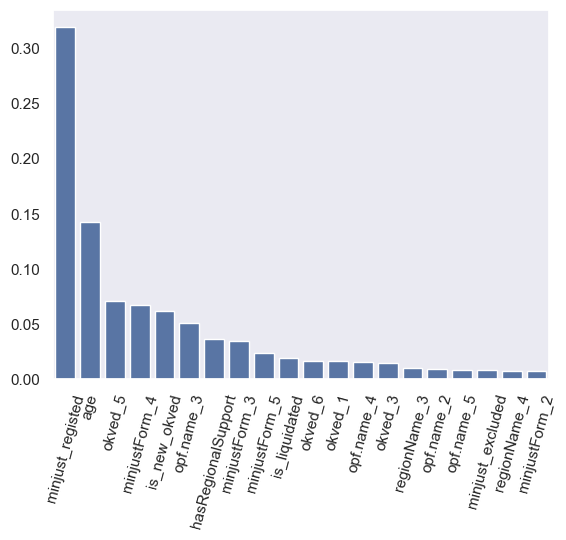

In [10]:
# Выдели топ-20 призанаков для модели древа решений
feat_importances = pd.Series(tree_model.feature_importances_, index=X_binary.columns).nlargest(20)
sns.barplot(feat_importances)
plt.xticks(rotation=75);

top_cols = feat_importances.index


Самый важный признак - статус "Зарегистрировано" в минюсте. Второй по важности: возраст НКО.
Теперь можно дать предварительный ответ на главный вопрос с брифе:

>Есть ли зависимость вероятности получения грантов от государства/госконтрактов:
>- от региона регистрации организации;
>- от возраста организации;
>- от экономической деятельности организации.

Возраст организации имеет решаюшее значение для определения факта получения господдержки. Класс отрасли экономической деятельности (ОКВЭД) важен наряду с формой в Минюсте, а также с видом ОКВЭД (старая или новая классификация). Регион организации оказывает минимальное значение для государства при выплате денежных средств, куда важнее факт получения региональной поддержки.

In [11]:
# Обучим модель на части признаков
tree_model = DecisionTreeClassifier(
    class_weight={0:1, 1:15},  # Больше веса minority
    max_depth=11,
    min_samples_leaf=20,
    random_state=42
)

# Обучаем модель 
tree_model.fit(X_train[top_cols], y_train)

# Делаем предсказания и считаем метрики
y_pred_train = tree_model.predict(X_train[top_cols])
y_pred_test = tree_model.predict(X_test[top_cols])

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict['Дерево решений_топ-20'] = metrics[0]
f1_dict['Дерево решений_топ-20'] = metrics[1]

TRAIN:
recall_score : 0.8639
f1_score:  0.2965
------------------------------
TEST:
recall_score : 0.8478
f1_score:  0.2916
------------------------------
Разница между тестом и трейном - 1.9 %


При использовании только 20 признаков нам удалось немного улучшить основную метрику - модель меньше поддавалась влиянию слабых признаков, которые по сути являются шумом для нее.

### Случайный лес

Дерево решений неплохо справилось со своей задачей. Посмотрим как справится беггинг из деревьев: случайный лес

In [12]:
# Обучим модель на части признаков
forest_model = RandomForestClassifier(
    class_weight={0:1, 1:15},  # Больше веса minority
    max_depth=  9,
    min_samples_leaf=20,
    random_state=42,
    n_estimators=200,
    n_jobs= -1
)

# Обучаем модель 
forest_model.fit(X_train, y_train)

# Делаем предсказания и считаем метрики
y_pred_train = forest_model.predict(X_train)
y_pred_test = forest_model.predict(X_test)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict['Случайный лес'] = metrics[0]
f1_dict['Случайный лес'] = metrics[1]

TRAIN:
recall_score : 0.8489
f1_score:  0.2967
------------------------------
TEST:
recall_score : 0.8433
f1_score:  0.2971
------------------------------
Разница между тестом и трейном - 0.7 %


In [13]:
# Выделим топ-20 призанков
feat_importances = pd.Series(forest_model.feature_importances_, index=X_binary.columns).nlargest(20)
top_cols = feat_importances.index


In [14]:
forest_model = RandomForestClassifier(
    class_weight={0:1, 1:15},  # Больше веса minority
    max_depth=  9,
    min_samples_leaf=20,
    random_state=42,
    n_estimators=200,
    n_jobs= -1
)

# Обучаем модель 
forest_model.fit(X_train[top_cols], y_train)

# Делаем предсказания и считаем метрики
y_pred_train = forest_model.predict(X_train[top_cols])
y_pred_test = forest_model.predict(X_test[top_cols])

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict['Случайный лес_топ-20'] = metrics[0]
f1_dict['Случайный лес_топ-20'] = metrics[1]

TRAIN:
recall_score : 0.8551
f1_score:  0.2902
------------------------------
TEST:
recall_score : 0.8517
f1_score:  0.2907
------------------------------
Разница между тестом и трейном - 0.4 %


Случайный лес также смог улучшить полученные метрики. Далее посмотрим на модели бустинга.

### Градиентный бустинг

#### *Xgboost*

Несмотря на то, что Xgboost достаточно силен с параметрами по умолчанию, из-за сильного дисбаланса нам придется поменять некоторые параметры, иначе алгоритм булет очень плохо сходиться или же выдаывать сильное переобучение на тренировочной выборке.

In [15]:
# Создание модели
xg_model = XGBClassifier(
        scale_pos_weight = 94 / 6,  # Дисбаланс
        max_depth = 3,
        earning_rate = 0.1,
        n_estimators = 1000,
        random_state = 42
)

# Обучаем модель 
xg_model.fit(X_train, y_train)

# Делаем предсказания и считаем метрики
y_pred_train = xg_model.predict(X_train)
y_pred_test = xg_model.predict(X_test)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict['Xgboost'] = metrics[0]
f1_dict['Xgboost'] = metrics[1]

TRAIN:
recall_score : 0.8585
f1_score:  0.3155
------------------------------
TEST:
recall_score : 0.8448
f1_score:  0.3113
------------------------------
Разница между тестом и трейном - 1.6 %


In [16]:
# Выделим топ-20 призанков
feat_importances = pd.Series(xg_model.feature_importances_, index=X_binary.columns).nlargest(20)
top_cols = feat_importances.index

# Обучим модель на части признаков

xg_model = XGBClassifier(
        scale_pos_weight = 94 / 6,  # Дисбаланс
        max_depth = 3,
        earning_rate = 0.1,
        n_estimators = 1500,
        random_state = 42
)

# Обучаем модель 
xg_model.fit(X_train[top_cols], y_train)

# Делаем предсказания и считаем метрики
y_pred_train = xg_model.predict(X_train[top_cols])
y_pred_test = xg_model.predict(X_test[top_cols])

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict['Xgboost_топ-20'] = metrics[0]
f1_dict['Xgboost_топ-20'] = metrics[1]

TRAIN:
recall_score : 0.8501
f1_score:  0.3022
------------------------------
TEST:
recall_score : 0.8431
f1_score:  0.3003
------------------------------
Разница между тестом и трейном - 0.8 %


Для моделей бустинга нет смысла выделять топовые признаки и обучать на них модели отдельно: метрики становтся хуже. XGBoost обучает деревья последовательно, каждое исправляет ошибки предыдущего. Шумовые признаки быстро получают нулевую важность и автоматически исключаются из обучения.

#### *Catboost*

Воспользуемся catboost -  алгоритмом градиентного бустинга с открытым исходным кодом, разработанный компанией «Яндекс». Главным его преимуществом, что он может работать с категориальными прзназнаками без их специальной обработки. 

Для начала проверим модель на "сырых" данных c параметрами по умолчанию.

In [17]:
# Разбиваем выборки на тренировочную и тестовую:
X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

# Список категориальных столбцов
categorical_features = [
    'regionName',
    'minjustForm',
    'opf.name',
    'admin_group',
    'okved'
]

catboost_model = CatBoostClassifier(
    auto_class_weights='Balanced', # Балансировка классов
    random_state=42,
        depth=4, 
    verbose=False)

# Обучаем в том числе на категориальных признаках
catboost_model.fit(
    X_train_cat, y_train,
    cat_features=categorical_features 
    )

# Делаем предсказания и считаем метрики
y_pred_train = catboost_model.predict(X_train_cat)
y_pred_test = catboost_model.predict(X_test_cat)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict['Catboost_cat_feat'] = metrics[0]
f1_dict['Catboost_cat_feat'] = metrics[1]


TRAIN:
recall_score : 0.8661
f1_score:  0.3290
------------------------------
TEST:
recall_score : 0.8469
f1_score:  0.3225
------------------------------
Разница между тестом и трейном - 2.3 %


Модель показала хорошие значения метрик, даже без обработки признаков. К сожалению из-за небольшого переобучения не удалось побитить метрику для модели случайного леса, хотя на трейн выборке зачения *recall* получились достаточно высокими. А теперь посмотрим, что получится на обработанных данных, на которых обучались другие модели.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y, test_size=0.2, stratify=y, random_state=42
    )

In [19]:
cat_model = CatBoostClassifier(
    auto_class_weights='Balanced', # Балансировка классов
    iterations=1000,
    eval_metric='Recall',  # делам фокус на recall
    learning_rate=0.1,
    depth=4,
    random_seed=42,
    verbose=False)

# Обучаем модель на бинарных данных
cat_model.fit(X_train, y_train)

# Делаем предсказания и считаем метрики
y_pred_train = cat_model.predict(X_train)
y_pred_test = cat_model.predict(X_test)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict['Catboost'] = metrics[0]
f1_dict['Catboost'] = metrics[1]

TRAIN:
recall_score : 0.8525
f1_score:  0.3157
------------------------------
TEST:
recall_score : 0.8431
f1_score:  0.3127
------------------------------
Разница между тестом и трейном - 1.1 %


На категориальных данных модель показала средние значения метрик. Модель, обученная на бинарных признаках выглядит предпочтительнее.

### Сравнение метрик

С помощью словарей recall_dict и f1_dict визуализируем полученные метрики

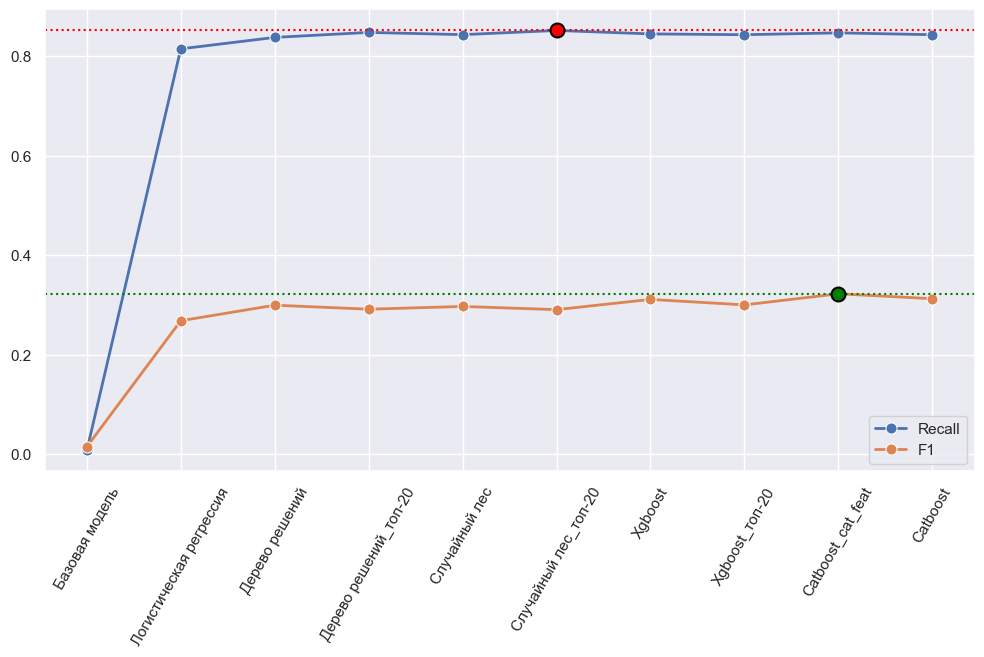

In [20]:
recall_dict['Базовая модель'] = 0.0078
f1_dict['Базовая модель']= 0.0153

plt.figure(figsize=(12, 6))

# Лучшие значения метрик
max_recall = max(recall_dict.values())
max_f1 = max(f1_dict.values())

max_recall_key = max(recall_dict, key=recall_dict.get)
max_f1_key = max(f1_dict, key=f1_dict.get)

# Строим основные линии
sns.lineplot(recall_dict, marker='o', markersize=8, linewidth=2, label='Recall')
sns.lineplot(f1_dict, marker='o', markersize=8, linewidth=2, label='F1')

# Горизонтальные линии — ориентиры максимумов
plt.axhline(max_recall, color='red', linestyle=':', lw=1.5)
plt.axhline(max_f1, color='green', linestyle=':', lw=1.5)

# Точки, отмечающие максимумы 
plt.scatter(
    max_recall_key, max_recall, color='red',
    s=100,zorder=5, edgecolors='black', linewidth=1.5
    )
plt.scatter(
    max_f1_key, max_f1, color='green',
    s=100, zorder=5, edgecolors='black', linewidth=1.5
    )

plt.xticks(rotation=60)
plt.legend()
plt.grid()
plt.show()


После обработки данных и при использовани параметров модели для борьбы с дисбалансом каждая из моделей показала метрики кратно превосходящие базовую модель. А если откинуть ее за скобки, то в целом разброс получился небольшим. 

# Target encoding

Попробуем иначе закодировать категориальные признаки по силе влияния по целевую переменную. А именно: вместо текстового значения в признаке будет стоять среднее значение таргета для данной категории. Чем выше среднее значение таргета для категории - тем выше ее влияние в глазах модели. Чтобы избежать чрезмерного влияние на переобучение и возможную утечку данных, мы будет пристально следить на тестовой и тренировочными метриками: если разница будет больше 5%, то такую модель нельзя будет внедрять с продакшен.

In [21]:
# Вычислить среднее по таргету для каждого категориального признака
X_target_ecnoding = X.copy()

region_target_mean = df.groupby('regionName')['has_support'].mean()
minjust_target_mean = df.groupby(['minjustForm'])['has_support'].mean()
opf_target_mean = df.groupby(['opf.name'])['has_support'].mean()
admin_target_mean = df.groupby(['admin_group'])['has_support'].mean()
okved_target_mean = df.groupby(['okved'])['has_support'].mean()

# Заменим значение средним значением
X_target_ecnoding['regionName'] = X_target_ecnoding ['regionName'].map(region_target_mean)
X_target_ecnoding['minjustForm'] = X_target_ecnoding['minjustForm'].map(minjust_target_mean)
X_target_ecnoding['opf.name'] = X_target_ecnoding['opf.name'].map(opf_target_mean)
X_target_ecnoding['admin_group'] = X_target_ecnoding['admin_group'].map(admin_target_mean)
X_target_ecnoding['okved'] = X_target_ecnoding['okved'].map(okved_target_mean)

In [22]:
# Убираем текстовые признаки и заново делаем разбиение на тест и трейн
X_target_ecnoding = X_target_ecnoding.select_dtypes(exclude=['object'])

X_train, X_test, y_train, y_test = train_test_split(
    X_target_ecnoding, y, test_size=0.2, stratify=y, random_state=42
    )

Проверим новые данные на топовых моделях из прошлой части:

In [23]:
# Добавим метрики топовой модели
recall_dict_new = {max_recall_key: max_recall}
f1_dict_new = {max_recall_key: f1_dict[max_recall_key]}

In [24]:
catb_model = CatBoostClassifier(
    auto_class_weights='Balanced', # Балансировка классов
    iterations=1000,
    eval_metric='Recall',  # делам фокус на recall
    learning_rate=0.1,
    depth=4,
    random_seed=42,
    verbose=False)

catb_model.fit(X_train, y_train)

# Делаем предсказания и считаем метрики
y_pred_train = catb_model.predict(X_train)
y_pred_test = catb_model.predict(X_test)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict_new['Catboost_target_ecnoding'] = metrics[0]
f1_dict_new['Catboost_target_ecnoding'] = metrics[1]

TRAIN:
recall_score : 0.8592
f1_score:  0.3205
------------------------------
TEST:
recall_score : 0.8515
f1_score:  0.3181
------------------------------
Разница между тестом и трейном - 0.9 %


In [25]:
xg_model = XGBClassifier(
        scale_pos_weight = 94 / 6,  # Дисбаланс
        max_depth = 3,
        earning_rate = 0.1,
        n_estimators = 1000,
        random_state = 42
)

xg_model.fit(X_train, y_train)

# Делаем предсказания и считаем метрики
y_pred_train = xg_model.predict(X_train)
y_pred_test = xg_model.predict(X_test)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict_new['XGboost_target_ecnoding'] = metrics[0]
f1_dict_new['XGboost_target_ecnoding'] = metrics[1]


TRAIN:
recall_score : 0.8692
f1_score:  0.3231
------------------------------
TEST:
recall_score : 0.8542
f1_score:  0.3179
------------------------------
Разница между тестом и трейном - 1.7 %


In [26]:
trees_model = RandomForestClassifier(
    class_weight={0:1, 1:15},  # Больше веса minority
    max_depth=10,
    #min_samples_leaf=20,
    random_state=42,
    n_estimators=500,
    n_jobs= -1
)

# Обучаем модель 
trees_model.fit(X_train, y_train)

# Делаем предсказания и считаем метрики
y_pred_train = trees_model.predict(X_train)
y_pred_test = trees_model.predict(X_test)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

recall_dict_new['Random_forest'] = metrics[0]
f1_dict_new['Random_forest'] = metrics[1]

TRAIN:
recall_score : 0.8546
f1_score:  0.3143
------------------------------
TEST:
recall_score : 0.8443
f1_score:  0.3121
------------------------------
Разница между тестом и трейном - 1.2 %


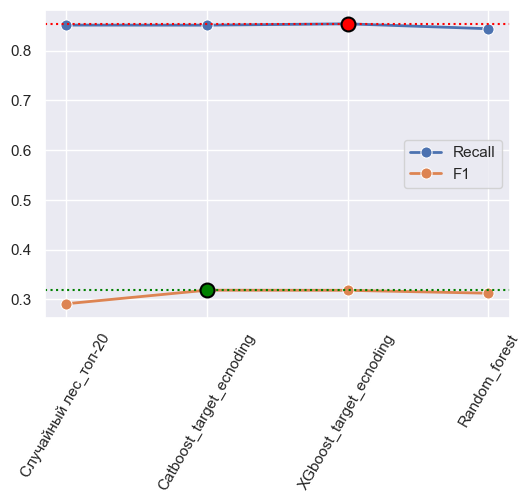

In [27]:
# Визуализируем полученные метрики
plt.figure(figsize=(6, 4))

max_recall = max(recall_dict_new.values())
max_f1 = max(f1_dict_new.values())

max_recall_key = max(recall_dict_new, key=recall_dict_new.get)
max_f1_key = max(f1_dict_new, key=f1_dict_new.get)

# Строим основные линии
sns.lineplot(recall_dict_new, marker='o', markersize=8, linewidth=2, label='Recall')
sns.lineplot(f1_dict_new, marker='o', markersize=8, linewidth=2, label='F1')

# Горизонтальные линии — ориентиры максимумов
plt.axhline(max_recall, color='red', linestyle=':', lw=1.5)
plt.axhline(max_f1, color='green', linestyle=':', lw=1.5)

# Точки, отмечающие максимумы (в тех же цветах, что и axhline)
plt.scatter(max_recall_key, max_recall, color='red',
            s=100, zorder=5, edgecolors='black', linewidth=1.5)

plt.scatter(max_f1_key, max_f1, color='green',
            s=100, zorder=5, edgecolors='black', linewidth=1.5)

plt.xticks(rotation=60)
plt.legend()
plt.grid()
plt.show()

Метрики получаются близкими друг к другу. У модели XGBoost получился максимальный *recall*, а это именна та метрика, которую мы бы хотели максимизировать. Выберем ее в качестве основной и дальше для нее будет подбирать оптимальный порог вероятности, а также гиперпараметры. Плюсом этой модели является то, что она заметно быстрее своих конкурентов обучается (примерно в 3-4 раза быстрее, чем  Catboost и RandomForest)

Посмотрим какие признаки каждая из моделей посчитала наиболее важными в процессе обучения. Поскольку методы *feature_importances_* возвращают данные в разных масштабах - то нам придется их стандартизировать для сравнения друг с другом.

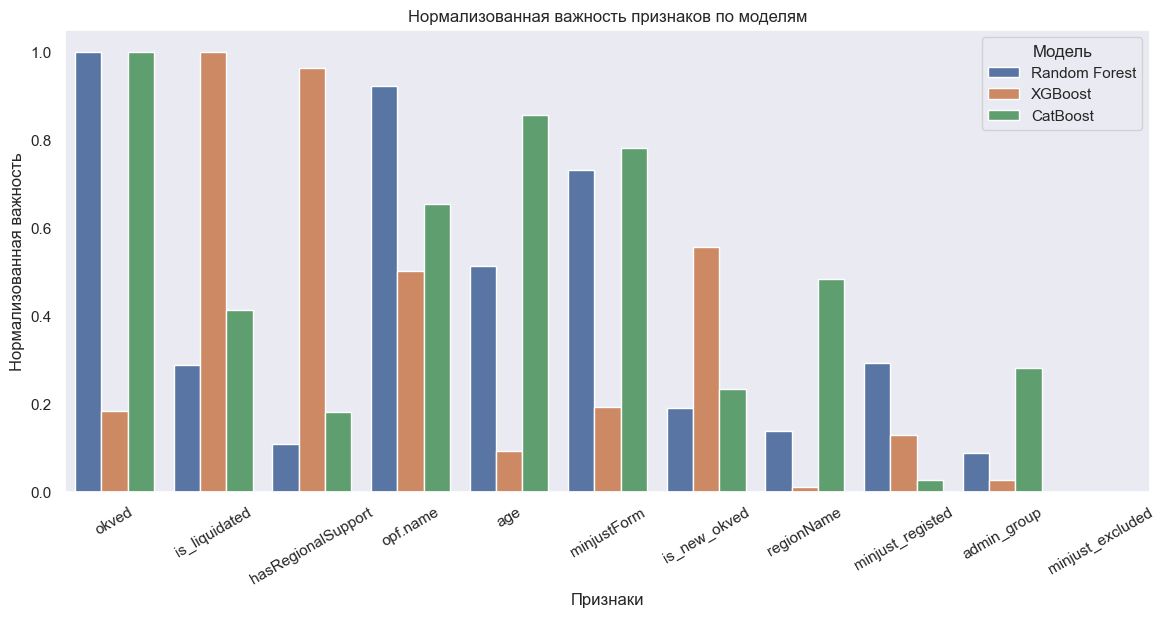

In [29]:
# Исходный DataFrame
feat_importances = pd.DataFrame({
    'CatBoost': catb_model.feature_importances_,
    'XGBoost': xg_model.feature_importances_,
    'Random Forest': trees_model.feature_importances_
}, index=X_target_ecnoding.columns)

# Нормализуем весь DataFrame сразу
scaler = MinMaxScaler()
normalized_importances = scaler.fit_transform(feat_importances)

feat_importances_normalized = pd.DataFrame(
    normalized_importances,
    columns=feat_importances.columns,
    index=feat_importances.index
)

# Расплавляем DataFrame для корректной работы seaborn
feat_melted = feat_importances_normalized.reset_index().melt(
    id_vars='index', 
    value_vars=feat_importances.columns,
    var_name='Model', 
    value_name='Importance'
).sort_values('Importance', ascending=False)

# Строим итоговый график
plt.figure(figsize=(14, 6))
sns.barplot(data=feat_melted, x='index', y='Importance', hue='Model')
plt.xticks(rotation=30)
plt.title('Нормализованная важность признаков по моделям')
plt.xlabel('Признаки')
plt.ylabel('Нормализованная важность')
plt.legend(title='Модель')


***Зависимость вероятности получения грантов/госконтрактов***

1. Важность признака *regionName* сильно варьируется в зависимости от модели

- *CatBoost* считает этот признак умеренно значимым (0.48 — это почти половина от максимальной важности в этой модели).
- *XGBoost* практически игнорирует регион (0.01).
- *Random Forest* придает ему небольшое значение (0.13).

**Вывод**: Зависимость неустойчивая. Она сильно зависит от алгоритма расчета. Для одних методов (CatBoost) регион важен, для других (XGBoost) — нет. Это может означать, что регион сам по себе не является прямым предиктором, но в сочетании с другими признаками (например, видом деятельности) может влиять на результат.

2. Зависимость от возраста организации (*age*)

- Для *CatBoost* — это один из ключевых признаков (0.86).
- Для *Random Forest* — средняя значимость (0.51).
- Для *XGBoost* — признак практически бесполезен (0.08).

**Вывод**: Наблюдается сильная зависимость возраста в двух из трех моделей. Вероятно, возраст организации влияет на получение поддержки (например, более опытные или, наоборот, молодые компании могут иметь преференции), но причина этого влияния должна быть дополнительно проверена.

3. Зависимость от экономической деятельности (*okved*)

- Для *Random Forest* и *CatBoost* — это самый важный признак (почти 1.00).
- Для *XGBoost* — важность низкая (0.18), но не нулевая.

**Вывод**: Признак критически важен в двух моделях из трех. Это говорит о том, что вид экономической деятельности организации (ОКВЭД) очень сильно влияет на вероятность получения грантов или госконтрактов. Очевидно, что государство поддерживает одни отрасли больше, чем другие.

>**Общий итог**

>Да, зависимость существует, но она неоднородна:

> - Наибольшая зависимость прослеживается от вида экономической деятельности (*okved*). Это самый стабильный и важный фактор.
> - Средняя зависимость наблюдается от возраста организации (*age*). Он важен, но его влияние по-разному интерпретируется моделями.
> - Слабая и неустойчивая зависимость — от региона (*regionName*). Регион может влиять косвенно, но не является определяющим фактором для всех моделей.

# Подбор гиперпараметров

In [ ]:
# Создаем scorer для recall
recall_scorer = make_scorer(recall_score)


def objective_recall(trial):
    """Оптимизация XGBoost под recall с Optuna."""
    params = {
        'max_depth': 3,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'learning_rate': trial.suggest_float(
            'learning_rate', 0.01, 0.1, log=True
        ),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 3.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 3.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 30),
        'random_state': 42,
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    
    model = XGBClassifier(**params)
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scores = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring=recall_scorer,
        n_jobs=-1
    )
    
    return scores.mean()


# Новая оптимизация для recall
study_recall = optuna.create_study(
    direction='maximize',
    study_name='xgboost_recall_optimization',
    storage='sqlite:///xgboost_recall.db',
    load_if_exists=True
)

study_recall.optimize(
    objective_recall,
    n_trials=20,
    show_progress_bar=True
)

print('Лучшие параметры для recall:', study_recall.best_params)
print('Лучший recall на CV:', study_recall.best_value)

[I 2026-02-23 18:47:48,712] Using an existing study with name 'xgboost_recall_optimization' instead of creating a new one.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-02-23 18:48:27,074] Trial 21 finished with value: 0.9034267912772586 and parameters: {'min_child_weight': 8, 'gamma': 0.06395939338242096, 'subsample': 0.8425815590072729, 'colsample_bytree': 0.8718453247307172, 'learning_rate': 0.07228294713294943, 'reg_alpha': 2.995503927662076, 'reg_lambda': 1.2651417010568593, 'n_estimators': 670, 'scale_pos_weight': 25.53159579021602}. Best is trial 13 with value: 0.912997785534662.
[I 2026-02-23 18:49:09,411] Trial 22 finished with value: 0.9116841196561949 and parameters: {'min_child_weight': 1, 'gamma': 0.01982758279192043, 'subsample': 0.7428313828718069, 'colsample_bytree': 0.8241199692592912, 'learning_rate': 0.015854714416273022, 'reg_alpha': 0.03680551879652385, 'reg_lambda': 0.01864885446675579, 'n_estimators': 971, 'scale_pos_weight': 29.687779264845922}. Best is trial 13 with value: 0.912997785534662.
[I 2026-02-23 18:49:51,893] Trial 23 finished with value: 0.9128101189805954 and parameters: {'min_child_weight': 2, 'gamma': 0.0

In [ ]:
best_model = XGBClassifier(**study_recall.best_params)

best_model.fit(X_train, y_train)

# Делаем предсказания и считаем метрики
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

metrics = calculate_metrics(y_pred_train, y_pred_test, y_train, y_test)

TRAIN:
recall_score : 0.9326
f1_score:  0.2783
------------------------------
TEST:
recall_score : 0.9156
f1_score:  0.2744
------------------------------
Разница между тестом и трейном - 1.8 %


С помощью подбора гиперпараметров нам удалось существенно улучшить значение метрики *recall*. Хотя и значения f1 несколько уменьшились.

# Выбор оптимального порога вероятности

Построем график распределения recall и f1 для уже обученной модели XGBoost при разных порогах вероятности

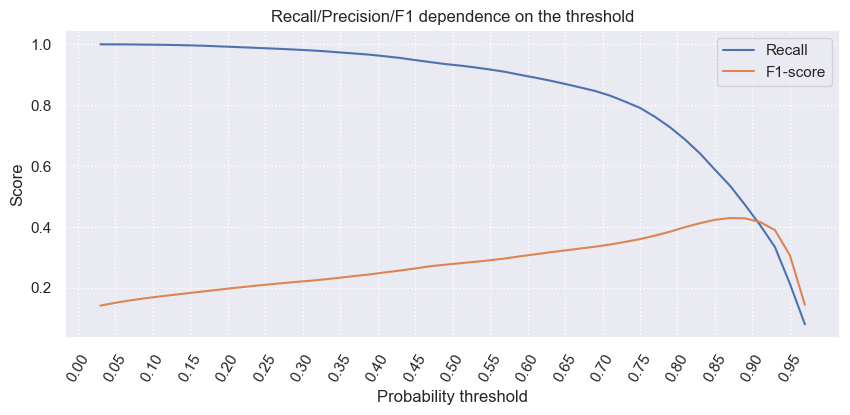

In [ ]:
y_proba_pred = best_model.predict_proba(X_train)[:, 1]
y_proba_pred = pd.Series(y_proba_pred)

recall_scores = []
f1_scores = []

thresholds = np.arange(0.03, 0.99, 0.02)

for threshold in thresholds:
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(recall_score(y_train, y_pred))
    f1_scores.append(f1_score(y_train, y_pred))
    
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('Recall и F1 в зависимости от порога вероятности')
ax.set_xlabel('Порог вероятности')
ax.set_ylabel('Значение метрики')
ax.set_xticks(np.arange(0, 1, 0.05))
ax.xaxis.set_tick_params(rotation=60)
ax.grid(linestyle=':')
ax.legend();

Ключевые наблюдения:

- Recall (синяя линия) начинается с значения близкого к 1.0 при низких порогах (около 0), что означает: модель изначально захватывает почти все реальные случаи получения грантов (максимальная полнота). По мере увеличения порога Recall плавно снижается — модель начинает пропускать всё больше «положительных» случаев.
- F1-score (оранжевая линия) стартует с низких значений (около 0.2) при малых порогах, затем растёт, достигая максимума в районе порога ~0.5–0.6, после чего снова падает при высоких порогах (близко к 1.0).
При порогах < 0.5 Recall остаётся высоким, но F1-score низкий — это зона избыточной полноты (много ложных срабатываний, низкая точность).
- При порогах > 0.6–0.7 Recall резко падает, а F1-score снижается — это зона избыточной точности (мало ложных срабатываний, но много пропущенных «положительных» случаев).

Вывод: Лучше всего оставить компромиссный порог около 0.5. При таком значении порога мы получаем метрику *recall* 0.9156, что является очень хорошим значением для прогноза получения денежных средств НКО.

# Финальный вывод

В ходе исследования была протестирована гипотеза о влиянии трех ключевых факторов на вероятность получения некоммерческими организациями государственного финансирования (грантов, субсидий, госконтрактов). Для анализа использовались данные проекта «Открытые НКО» (более 540 тыс. организаций) и три модели машинного обучения: *Random Forest, XGBoost* и *CatBoost*.

<u>Ответы на ключевые вопросы</u>:

1. Вид экономической деятельности (*okved*)	Высокая	Является наиболее стабильным и важным фактором. Модели Random Forest и CatBoost присвоили ему максимальную важность (около 1.0). Это подтверждает, что государство поддерживает одни отрасли значительно активнее других.
2 .Возраст организации (*age*)	Средняя	Демонстрирует устойчивую зависимость в двух из трех моделей (CatBoost – 0.86, Random Forest – 0.51). Вероятно, опыт организации или, наоборот, поддержка молодых НКО играют роль, но характер влияния требует дополнительного анализа.
3. Регион регистрации (*regionName*)	Низкая/Неустойчивая	Влияние сильно варьируется в зависимости от модели: от практически нулевого (*XGBoost* – 0.01) до умеренного (*CatBoost* – 0.48). Это указывает на то, что регион сам по себе не является прямым предиктором, но может влиять косвенно, в сочетании с другими факторами.

<u>Достигнутые метрики качества</u>:

Для борьбы с сильным дисбалансом классов (лишь ~6% НКО получают поддержку) применялись взвешивание классов и подбор гиперпараметров.

*Базовая модель:* Recall = 0.0078, F1 = 0.0153

*Лучшая модель:* *XGBoost* с оптимизированными гиперпараметрами: Recall = 0.9156, F1 = 0.2744

Основной фокус был сделан на максимизацию полноты (recall), т.е. на способность модели находить организации, получающие поддержку. Удалось добиться значительного прироста этой метрики (с <1% до 91.6%) ценой некоторого снижения точности, что отражается в значении F1-меры.

**Заключение**:

Зависимость вероятности получения грантовотгосударства/госконтрактов существует, однако она неоднородна. Наибольшее и наиболее стабильное влияние оказывает вид экономической деятельности. Это ключевой фактор, определяющий шансы НКО на получение господдержки. Возраст организации является важным, но второстепенным фактором, интерпретация которого может различаться в зависимости от модели. Регион регистрации не является определяющим фактором сам по себе. Его низкая и неустойчивая важность говорит о том, что федеральные программы поддержки в меньшей степени ориентированы на географию, чем на отраслевую принадлежность организации.

*Таким образом, при планировании стратегии получения государственного финансирования НКО в первую очередь следует учитывать соответствие ее деятельности приоритетным направлениям поддержки (ОКВЭД), во вторую — возрастные характеристики организации. Региональный фактор требует более тонкого анализа в связке с отраслевой спецификой.*